In [1]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

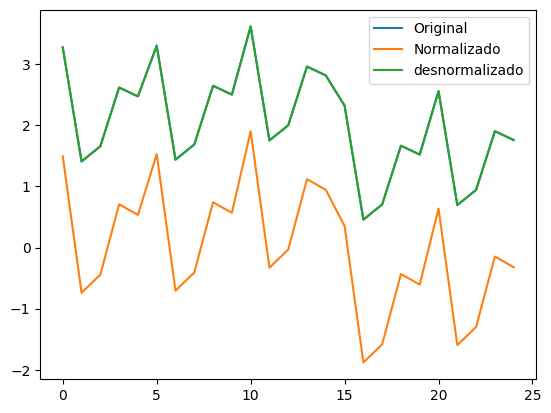

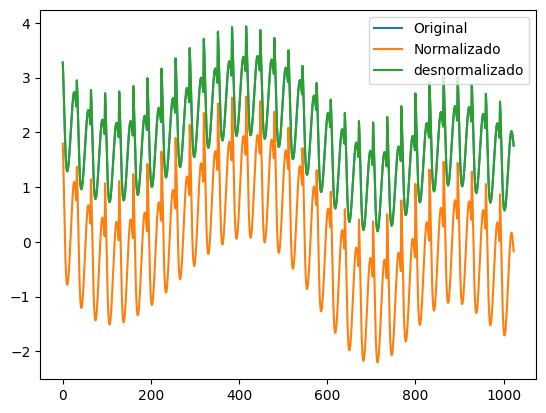

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def function(grid):
    x = np.linspace(1, 0, grid)
    y = np.linspace(1, 0, grid)
    x, y = np.meshgrid(x, y)
    z = 1.3356 * (1.5 * (1 - x))+np.exp(2 * x - 1) * np.sin(3 * np.pi * (x - 0.6)**2)+np.exp(3*(y - 0.5)) * np.sin(4 * np.pi * (y - 0.9)**2)
    return x, y, z

def create_dataframe(grid):
   x, y, z = function(grid)
   data = {'X': x.flatten(), 'Y': y.flatten(), 'Z': z.flatten()}
   df = pd.DataFrame(data)
   return df

def show_norm(df, label="function", plot=False):
    df_norm = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df_norm), columns=df_norm.columns)

    if (plot):
        df.plot(title=f"{label}: Original data")
        df_norm.plot(title=f"{label}: Normalized data")
        df_denorm.plot(title=f"{label}: Denormalized data")
    return (df_norm)


def test_out_scaler(df):
    out = df["Z"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()


df_25 = create_dataframe(grid=5)
df_25_norm = show_norm(df_25)
test_out_scaler(df_25)

df_1000 = create_dataframe(grid=32)
df_1000_norm = show_norm(df_1000)
test_out_scaler(df_1000)



In [3]:
def split_df(df):
    _input = np.vstack([df['X'], df['Y']]).T
    _output = np.array(df['Z'])
    return (_input, _output)

In [10]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import tf_levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def compute_k(self):
        total_parameters = 0
        for layer in self.model.layers:
            weights = layer.get_weights()
            if len(weights) > 0:  
                for w in weights:
                    total_parameters += np.prod(w.shape)
        return total_parameters
        
    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer

        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):

        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=lm.loss.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'])

        self.lm_model = lm.model.ModelWrapper(
            tf.keras.models.clone_model(self.model))
  

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.loss.SparseCategoricalCrossentropy(from_logits=True))
        
        return(self.lm_model)


In [11]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error 

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
        self.k = 0

    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)
      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, input, output, sup_input, sup_output):
      input_train, input_vt, output_train, output_vt = train_test_split(input, output, test_size=0.3, shuffle = True)
      input_val, input_test, output_val, output_test = train_test_split(input_vt, output_vt, test_size=0.5, shuffle = True)

      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(input_test, output_test)
      self.vt_dataset, self.vt_input, self.vt_output = self.create_dataset(input_vt, output_vt)
      self.sup_dataset, self.sup_input, self.sup_output = self.create_dataset(sup_input, sup_output)
      self.dataset, self.input, self.output = self.create_dataset(input, output)

      self._data = (input, output)
      self._train = (input_train, output_train)
      self._vt = (input_vt, output_vt)
      self._val = (input_val, output_val)
      self._test = (input_test, output_test)
      self._sup = (sup_input, sup_output)

    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)

      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)
    
    def get_new_metrics(self, orig, pred, r2, mse):
      n = len(orig) # N: quantidade de saidas
      k = self.k
      waste = (orig.flatten() - pred.flatten())

      mape = mean_absolute_percentage_error(orig, pred)  
      r2_adj = 1 - (((n - 1)/(n - k - 1)) * (1 - r2))
      rsd = np.sqrt(np.sum(waste ** 2) / (n - 2))
      rmse = root_mean_squared_error(orig, pred)          
      aic = (-2 * np.log(mse)) + (2 * k)
      bic = (-2 * np.log(mse)) + (k * np.log(n))
      return (mape, r2_adj, rsd, rmse, aic, bic)
      

    def get_metrics(self):
          # Calculando a saida com os dados normalizados
          pred = self.lm_model.predict(self.input).flatten()
          test_pred = self.lm_model.predict(self.test_input).flatten()
          val_pred = self.lm_model.predict(self.val_input).flatten()
          vt_pred = self.lm_model.predict(self.vt_input).flatten()
          sup_pred = self.lm_model.predict(self.sup_input).flatten()

          # Calculando as metricas com a saida desnormalizada
          pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
          test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
          val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
          vt_pred_denorm = out_scaler.inverse_transform(vt_pred.reshape(-1, 1))
          sup_pred_denorm = out_scaler.inverse_transform(sup_pred.reshape(-1, 1))

          out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
          test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
          val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
          vt_denorm = out_scaler.inverse_transform(self._vt[1].reshape(-1, 1))    
          sup_denorm = out_scaler.inverse_transform(self._sup[1].reshape(-1, 1))

          r2 = r2_score(out_denorm, pred_denorm)
          r2_test = r2_score(test_denorm, test_pred_denorm)
          r2_val = r2_score(val_denorm, val_pred_denorm)
          r2_vt = r2_score(vt_denorm,  vt_pred_denorm)
          r2_sup = r2_score(sup_denorm,  sup_pred_denorm)

          mse = mean_squared_error(out_denorm, pred_denorm)
          mse_test = mean_squared_error(test_denorm, test_pred_denorm)
          mse_val = mean_squared_error(val_denorm, val_pred_denorm)
          mse_vt = mean_squared_error(vt_denorm,  vt_pred_denorm)
          mse_sup = mean_squared_error(sup_denorm,  sup_pred_denorm)
          
          mape, r2_adj, rsd, rmse, aic, bic = self.get_new_metrics(out_denorm, pred_denorm, r2, mse)
          metrics = {
                          'r2': r2,
                          'r2_sup': r2_sup,
                          'r2_test': r2_test,
                          'r2_val': r2_val,
                          'r2_vt': r2_vt,
                          'mse': mse,
                          'mse_sup': mse_sup,
                          'mse_test': mse_test,
                          'mse_val': mse_val,
                          'mse_vt': mse_vt,
                          'mape': mape,
                          'rmse': rmse,
                          'r2_adj': r2_adj,
                          'rsd': rsd,
                          'aic': aic,
                          'bic': bic
                          }

          return metrics

In [12]:
import pickle
from itertools import product

class Tester:
  def __init__(self, run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input_25, self.output_25 = split_df(df_25_norm)
    self.input_1000, self.output_1000 = split_df(df_1000_norm)
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=2,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)
    trainer.k = shuffler.compute_k()

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"../models/{fileName}.keras"
    open(path,'w').close()
    model.save_weights(path)

  def SaveDataset(self, trainer, fileName):
    path = f"../dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._vt, trainer._val, trainer._test), f)
      
  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] <= boundarie): # should be >= to acsending metrics
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    return(save)

  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinacao{count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self.input_25, self.output_25, self.input_1000, self.output_1000)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults('mse_sup', header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'../results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

# Treinando com 25 dados


In [13]:
tester = Tester(run_times=25, dataset_run_times=10)
tester.Loop(sort_by='mse',
            boundarie = 0.5,
            hidden_sizes = [[1,2], [1, 3], [1, 4], [1, 5], [1, 6],[2, 1]],
            regularizers=[0.2, 0.05],
            learning_rate=[0.01, 0.1])

Testando combinacao1: Hidden Size=[1, 2], regularizer=0.2, learning_rate=0.01
+++++++++++ [1_0] | 1 ++++++++++++++++++


2025-05-18 01:16:45.337396: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at sparse_xent_op.cc:102 : INVALID_ARGUMENT: Received a label value of -1 which is outside the valid range of [0, 1).  Label values: 0 1 0 -1 -1 -1 -1 0 0 0 0 0 0 1 1 0 0


InvalidArgumentError: Graph execution error:

Detected at node SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits defined at (most recent call last):
  File "/opt/conda/envs/tf_env/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/opt/conda/envs/tf_env/lib/python3.10/runpy.py", line 86, in _run_code

  File "/opt/conda/envs/tf_env/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/opt/conda/envs/tf_env/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/opt/conda/envs/tf_env/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/opt/conda/envs/tf_env/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/opt/conda/envs/tf_env/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/opt/conda/envs/tf_env/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/opt/conda/envs/tf_env/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/opt/conda/envs/tf_env/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/opt/conda/envs/tf_env/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/opt/conda/envs/tf_env/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/opt/conda/envs/tf_env/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/opt/conda/envs/tf_env/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/opt/conda/envs/tf_env/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/opt/conda/envs/tf_env/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/opt/conda/envs/tf_env/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3077, in run_cell

  File "/opt/conda/envs/tf_env/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3132, in _run_cell

  File "/opt/conda/envs/tf_env/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/opt/conda/envs/tf_env/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3336, in run_cell_async

  File "/opt/conda/envs/tf_env/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3519, in run_ast_nodes

  File "/opt/conda/envs/tf_env/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3579, in run_code

  File "/tmp/ipykernel_37595/423184709.py", line 2, in <module>

  File "/tmp/ipykernel_37595/1755055442.py", line 61, in Loop

  File "/tmp/ipykernel_37595/1755055442.py", line 43, in LoopWeights

  File "/tmp/ipykernel_37595/1755055442.py", line 24, in Train

  File "/tmp/ipykernel_37595/1784717495.py", line 43, in train_using_lm

  File "/opt/conda/envs/tf_env/lib/python3.10/site-packages/tf_levenberg_marquardt/model.py", line 109, in fit

  File "/opt/conda/envs/tf_env/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/opt/conda/envs/tf_env/lib/python3.10/site-packages/keras/src/engine/training.py", line 1807, in fit

  File "/opt/conda/envs/tf_env/lib/python3.10/site-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/opt/conda/envs/tf_env/lib/python3.10/site-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/opt/conda/envs/tf_env/lib/python3.10/site-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/opt/conda/envs/tf_env/lib/python3.10/site-packages/tf_levenberg_marquardt/model.py", line 71, in train_step

  File "/opt/conda/envs/tf_env/lib/python3.10/site-packages/tf_levenberg_marquardt/training.py", line 359, in train_step

  File "/opt/conda/envs/tf_env/lib/python3.10/site-packages/tf_levenberg_marquardt/training.py", line 241, in _train_step

  File "/opt/conda/envs/tf_env/lib/python3.10/site-packages/tf_levenberg_marquardt/training.py", line 197, in _init_gauss_newton_overdetermined

  File "/opt/conda/envs/tf_env/lib/python3.10/site-packages/tf_levenberg_marquardt/training.py", line 135, in _compute_jacobian

  File "/opt/conda/envs/tf_env/lib/python3.10/site-packages/tf_levenberg_marquardt/loss.py", line 96, in residuals

  File "/opt/conda/envs/tf_env/lib/python3.10/site-packages/keras/src/losses.py", line 2454, in sparse_categorical_crossentropy

  File "/opt/conda/envs/tf_env/lib/python3.10/site-packages/keras/src/backend.py", line 5775, in sparse_categorical_crossentropy

Received a label value of -1 which is outside the valid range of [0, 1).  Label values: 0 1 0 -1 -1 -1 -1 0 0 0 0 0 0 1 1 0 0
	 [[{{node SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference__compute_jacobian_1979]